In [1]:
import numpy as np
import pandas
import pylab as plt  # matplotlib的一个子包
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score  # R square

import sys 
sys.path.append(r'C:\\Users\\demo\\workplace\\Time-Series-Prediction-with-LSTM\\')  # 要用绝对路径
from utils import eemd_tools, data_tools, networks_factory, data_metrics
from utils.constants import const

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

# 导入数据

In [3]:
data_multi = np.load(const.PROJECT_DIR + "data/eemd/apple/data_multi.npy")
print("# shape", data_multi.shape)  # not .shape()

# shape (1901, 4)


## data preprocessing

In [4]:
# normalize features
scaler = data_tools.Po_MinMaxScaler
scaled = scaler.fit_transform(data_multi)

output = 1
lag = const.LOOK_BACK

reframed = data_tools.series_to_supervised(scaled, lag, output)
# drop columns we don't want to predict
index_drop = [-j-1 for j in range(data_multi.shape[1] - 1)]
reframed.drop(reframed.columns[index_drop], axis=1, inplace=True)
data_supervised = reframed.values
print("# shape:", reframed.shape)
print(len(data_multi) == len(reframed) + lag)
# print(reframed.head(3))

# split into train and test sets
train_size = int(len(data_supervised) * const.TRAIN_SCALE)
test_size = len(data_supervised) - train_size
train_data, test_data = data_supervised[0:train_size,:], data_supervised[train_size:len(data_multi),:]
print(len(train_data), len(test_data))
print(len(data_supervised) == len(train_data) + len(test_data)) 
# print(train_data)

# shape: (1871, 121)
True
1496 375
True


In [5]:
# split into input and outputs
train_X, train_Y = train_data[:, :-1], train_data[:, -1]
test_X, test_Y = test_data[:, :-1], test_data[:, -1]
print("# shape:", train_X.shape)
print("# shape:", train_Y.shape)

# shape: (1496, 120)
# shape: (1496,)


In [6]:
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

# shuffle train set (include validation set)
trainX_sparse = coo_matrix(train_X)  # sparse matrix
train_X, trainX_sparse, train_Y = shuffle(train_X, trainX_sparse, train_Y, random_state=0)

# LSTM

In [7]:
time_steps = lag
n_dims = 4  # magic number !
n_lstm_neurons = 32
n_epoch = networks_factory.EPOCHS
n_batch_size = networks_factory.BATCH_SIZE

In [8]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]//time_steps))
test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]//time_steps))
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(1496, 30, 4) (1496,)
(375, 30, 4) (375,)


In [9]:
from keras.models import load_model
from keras import optimizers

model_dir = const.PROJECT_DIR + "data/eemd/apple/apple0331/"
model = load_model(model_dir + "lstm_model.h5")

In [10]:
# Time-Based
learning_rate = 0.05  # default: 0.01
decay_rate = learning_rate / n_epoch
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False) 

# Drop-Based

In [11]:
model.compile(loss='mean_squared_error', optimizer=sgd)

print("# start training...")
history = model.fit(train_X, train_Y, epochs=10, batch_size=n_batch_size, validation_data=(test_X, test_Y), 
                verbose=0, callbacks=[networks_factory.ES]) 

# start training...


In [12]:
# make a prediction
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# invert predictions
inv_trainP, inv_trainY = data_tools.inv_transform_multi(scaler, train_X, train_predict, train_Y)
inv_testP, inv_testY = data_tools.inv_transform_multi(scaler, test_X, test_predict, test_Y)

# calculate RMSE, MAPE, Dstat
train_rmse = sqrt(mean_squared_error(inv_trainP, inv_trainY))
test_rmse = sqrt(mean_squared_error(inv_testP, inv_testY))
print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))
train_mape = data_metrics.MAPE(inv_trainP, inv_trainY)
test_mape = data_metrics.MAPE(inv_testP, inv_testY)
print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))
train_ds = data_metrics.Dstat(inv_trainP, inv_trainY)
test_ds = data_metrics.Dstat(inv_testP, inv_testY)
print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds))

Train RMSE: 0.4840, Test RMSE: 0.3349
Train MAPE: 0.0307, Test MAPE: 0.0307
Train Dstat: 0.9505, Test Dstat: 0.7139


# Plot

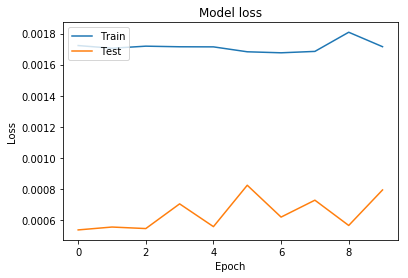

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()